In [ ]:
import pandas as pd
from pathlib import Path

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve().parent

# Model input directory
MODEL_INPUT_DIR = PROJECT_ROOT / "data" / "processed" / "model_input"

# Input CSV path
CSV_PATH = MODEL_INPUT_DIR / "clinvar_balanced_seq_101bp.csv"

# Sanity check
assert CSV_PATH.exists(), f"Model input CSV not found at {CSV_PATH}"

# Load dataframe
df = pd.read_csv(CSV_PATH)

print("Loaded dataframe with shape:", df.shape)
df.head()


In [22]:

# Report dimensions
print("DataFrame shape (rows, columns):", df.shape)

# Show column names
print("Column names:")
print(df.columns.tolist())

# Rename columns to match model pipeline
df = df.rename(columns={
    "chrom": "Chromosome",
    "pos": "Start",
    "ref": "ReferenceAllele",
    "alt": "AlternateAllele",
    "seq_ref": "ref_sequence",
    "seq_alt": "alt_sequence",
    "clinical_group": "ClinicalSignificance", 
    "functional_class": "functional_class"
})

# Confirm new columns
print(df.columns.tolist())
print("Shape:", df.shape)

# Check class balance
print(df["ClinicalSignificance"].value_counts())

# Check sequence lengths
print(df["ref_sequence"].str.len().describe())
print(df["alt_sequence"].str.len().describe())

# Check ref/alt consistency at center (optional quick peek)
df[["ReferenceAllele", "AlternateAllele"]].head()


DataFrame shape (rows, columns): (311007, 14)
Column names:
['chrom', 'pos', 'ref', 'alt', 'clnsig', 'review_status', 'molecular_consequence', 'geneinfo', 'disease_name', 'clinical_group', 'functional_class', 'seq_ref', 'seq_alt', 'seq_status']
['Chromosome', 'Start', 'ReferenceAllele', 'AlternateAllele', 'clnsig', 'review_status', 'molecular_consequence', 'geneinfo', 'disease_name', 'ClinicalSignificance', 'functional_class', 'ref_sequence', 'alt_sequence', 'seq_status']
Shape: (311007, 14)
ClinicalSignificance
pathogenic    149702
vus            85646
benign         75659
Name: count, dtype: int64
count    311007.0
mean        101.0
std           0.0
min         101.0
25%         101.0
50%         101.0
75%         101.0
max         101.0
Name: ref_sequence, dtype: float64
count    311007.0
mean        101.0
std           0.0
min         101.0
25%         101.0
50%         101.0
75%         101.0
max         101.0
Name: alt_sequence, dtype: float64


,ReferenceAllele,AlternateAllele
0,G,A
1,G,A
2,T,G
3,G,C
4,C,T


In [23]:
N_TOTAL = 1000

df = (
    df
    .groupby("ClinicalSignificance", group_keys=False)
    .apply(lambda x: x.sample(
        n=min(len(x), N_TOTAL // df["ClinicalSignificance"].nunique()),
        random_state=42
    ))
    .reset_index(drop=True)
)

print(df.shape)
print(df["ClinicalSignificance"].value_counts())
df.head()

(999, 14)
ClinicalSignificance
benign        333
pathogenic    333
vus           333
Name: count, dtype: int64


/var/folders/t7/xlq3thrd3bn646lmxy5vp3800000gn/T/ipykernel_27952/2511539740.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


,Chromosome,Start,ReferenceAllele,AlternateAllele,clnsig,review_status,molecular_consequence,geneinfo,disease_name,ClinicalSignificance,functional_class,ref_sequence,alt_sequence,seq_status
0,chrX,27748227,C,A,Likely_benign,"criteria_provided,_single_submitter",SO:0001583|missense_variant,DCAF8L2:347442,Inborn_genetic_diseases,benign,missense,GTTGTGTACAGCCACGATGGCACAGAGCTGCTAGCCAGCTACAATG...,GTTGTGTACAGCCACGATGGCACAGAGCTGCTAGCCAGCTACAATG...,ok
1,chr13,110511968,C,T,Likely_benign,"criteria_provided,_multiple_submitters,_no_con...",SO:0001583|missense_variant,COL4A2:1284,COL4A2-related_condition|not_provided|Porencep...,benign,missense,CCCCCTCTCTGTGCAGCACACGGCGGCGGGAGACGAAGGCGGTGGC...,CCCCCTCTCTGTGCAGCACACGGCGGCGGGAGACGAAGGCGGTGGC...,ok
2,chr1,6473333,G,C,Benign,"criteria_provided,_multiple_submitters,_no_con...",SO:0001583|missense_variant,PLEKHG5:57449,not_specified|not_provided|Charcot-Marie-Tooth...,benign,missense,TGAAAAAGCCGCTGAAGCGACTGGCCGCCCGGTTCTTCCAGCTGTC...,TGAAAAAGCCGCTGAAGCGACTGGCCGCCCGGTTCTTCCAGCTGTC...,ok
3,chr7,27128971,A,G,Benign,"criteria_provided,_single_submitter","SO:0001624|3_prime_UTR_variant,SO:0001627|intr...",HOXA3:3200|HOXA4:3201,not_provided,benign,utr,TGTAGCCATCTCAAAAGTATTTGATACCAAGTAGTCCTTCTCAGGT...,TGTAGCCATCTCAAAAGTATTTGATACCAAGTAGTCCTTCTCAGGT...,ok
4,chr6,111381327,A,T,Likely_benign,"criteria_provided,_single_submitter",SO:0001583|missense_variant,REV3L:5980,not_provided,benign,missense,TTTCTCTGAATTACAATACTGAATATTTATGGTAGCACTGTTACTT...,TTTCTCTGAATTACAATACTGAATATTTATGGTAGCACTGTTACTT...,ok


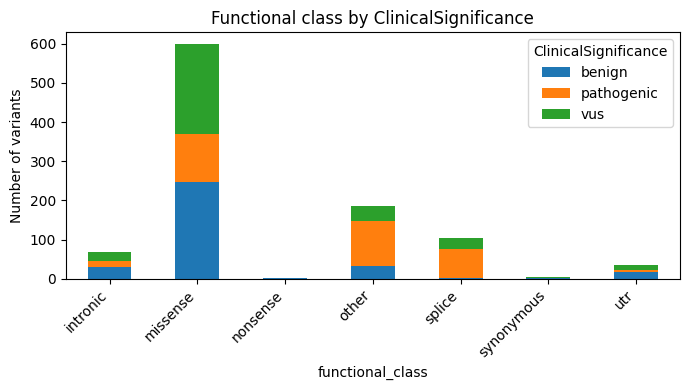

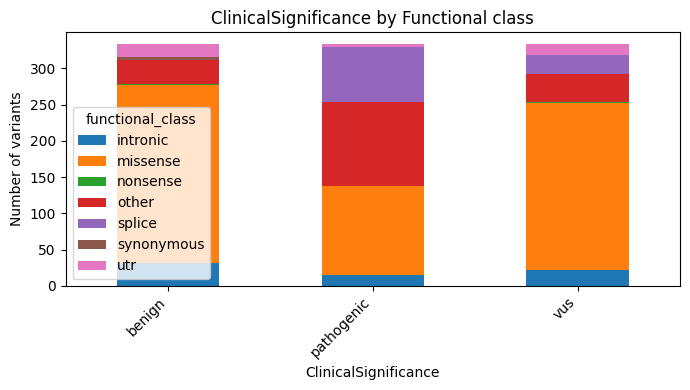

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

ct_fc_cs = pd.crosstab(df["functional_class"], df["ClinicalSignificance"])

ct_fc_cs.plot(
    kind="bar",
    stacked=True,
    figsize=(7, 4)
)
plt.ylabel("Number of variants")
plt.title("Functional class by ClinicalSignificance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

ct_cs_fc = ct_fc_cs.T

ct_cs_fc.plot(
    kind="bar",
    stacked=True,
    figsize=(7, 4)
)
plt.ylabel("Number of variants")
plt.title("ClinicalSignificance by Functional class")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




In [25]:
import torch
from transformers import AutoTokenizer, AutoModel

# Select device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Load model and tokenizer
model_name = "InstaDeepAI/nucleotide-transformer-500m-human-ref"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)
model = model.to(device)
model.eval()

print("Model loaded")

@torch.no_grad()
def get_lastlayer_mean_attention(sequence: str):
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    out = model(**inputs)

    # attentions: tuple of length num_layers
    # each element: (batch, heads, L, L)
    last = out.attentions[-1][0]           # (heads, L, L)
    A = last.mean(dim=0)                   # (L, L) average heads
    input_ids = inputs["input_ids"][0]     # (L,)
    return A, input_ids

def attention_received(A: torch.Tensor):
    # A is (L, L)
    return A.sum(dim=0)  # (L,) column sum

def find_variant_token_index(ref_ids: torch.Tensor, alt_ids: torch.Tensor):
    # returns the first differing token position
    diffs = (ref_ids != alt_ids).nonzero(as_tuple=False).flatten()
    if len(diffs) == 0:
        return None, []
    return int(diffs[0].item()), diffs.cpu().numpy().tolist()

Using device: mps


Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-500m-human-ref and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


In [26]:
from tqdm.auto import tqdm
import numpy as np

records = []

max_dist = 50      # distance-decay will be 0..50 tokens
local_window = 5   # your existing local metric window

for idx, row in tqdm(df.iterrows(), total=len(df)):
    ref_seq = row["ref_sequence"]
    alt_seq = row["alt_sequence"]
    label = row["ClinicalSignificance"]

    try:
        # 1) Run model and extract last-layer mean-head attention
        A_ref, ids_ref = get_lastlayer_mean_attention(ref_seq)
        A_alt, ids_alt = get_lastlayer_mean_attention(alt_seq)

        # 2) Convert attention matrices to "attention received" per token
        recv_ref = attention_received(A_ref)
        recv_alt = attention_received(A_alt)

        # 3) Delta per token (Alt - Ref)
        delta = (recv_alt - recv_ref).detach().cpu().numpy()  # shape (L,)

        # 4) Find which token position changed between ref and alt
        var_token, diff_tokens = find_variant_token_index(ids_ref.detach().cpu(), ids_alt.detach().cpu())

        # -------------------------------
        # STEP 0 (NEW): Distance profile
        # -------------------------------
        dist_profile = [np.nan] * (max_dist + 1)
        if var_token is not None:
            for d in range(max_dist + 1):
                vals = []
                left = var_token - d
                right = var_token + d

                if 0 <= left < len(delta):
                    vals.append(abs(delta[left]))
                if right != left and 0 <= right < len(delta):
                    vals.append(abs(delta[right]))

                if len(vals) > 0:
                    dist_profile[d] = float(np.mean(vals))

        # 5) Summary metrics (existing)
        abs_delta = np.abs(delta)
        max_abs = float(abs_delta.max())
        mean_abs = float(abs_delta.mean())
        sum_abs = float(abs_delta.sum())

        # 6) Local window summary (existing)
        if var_token is not None:
            lo = max(0, var_token - local_window)
            hi = min(len(delta), var_token + local_window + 1)
            local_sum_abs = float(np.abs(delta[lo:hi]).sum())
            local_max_abs = float(np.abs(delta[lo:hi]).max())
            delta_at_var = float(delta[var_token])
        else:
            local_sum_abs = np.nan
            local_max_abs = np.nan
            delta_at_var = np.nan

        # 7) Store results
        records.append({
            "Chromosome": row["Chromosome"],
            "Start": int(row["Start"]),
            "ReferenceAllele": row["ReferenceAllele"],
            "AlternateAllele": row["AlternateAllele"],
            "ClinicalSignificance": label,
            "functional_class": row["functional_class"],
            "token_length": int(len(delta)),
            "variant_token_index": var_token,
            "diff_token_indices": str(diff_tokens),

            "max_abs_delta_received": max_abs,
            "mean_abs_delta_received": mean_abs,
            "sum_abs_delta_received": sum_abs,
            "local_sum_abs_delta_received_w5": local_sum_abs,
            "local_max_abs_delta_received_w5": local_max_abs,
            "delta_received_at_variant_token": delta_at_var,

            # NEW FIELD:
            "dist_profile_abs_delta_received": dist_profile
        })

    except Exception as e:
        records.append({
            "Chromosome": row["Chromosome"],
            "Start": int(row["Start"]),
            "ReferenceAllele": row["ReferenceAllele"],
            "AlternateAllele": row["AlternateAllele"],
            "ClinicalSignificance": label,
            "functional_class": row["functional_class"],
            "error": str(e)
        })

res = pd.DataFrame(records)
print("Done. Errors:", res["error"].notna().sum() if "error" in res.columns else 0)
res.head()

100%|████████████████████████████████████████████████████████████████████████████| 999/999 [00:41<00:00, 23.89it/s]

Done. Errors: 0


,Chromosome,Start,ReferenceAllele,AlternateAllele,ClinicalSignificance,functional_class,token_length,variant_token_index,diff_token_indices,max_abs_delta_received,mean_abs_delta_received,sum_abs_delta_received,local_sum_abs_delta_received_w5,local_max_abs_delta_received_w5,delta_received_at_variant_token,dist_profile_abs_delta_received
0,chrX,27748227,C,A,benign,missense,22,9,[9],0.292700,0.101531,2.233684,1.243476,0.292700,0.261932,"[0.26193180680274963, 0.03419853746891022, 0.1..."
1,chr13,110511968,C,T,benign,missense,22,9,[9],0.438835,0.132814,2.921915,1.312976,0.238181,-0.183374,"[0.1833740770816803, 0.1656576246023178, 0.120..."
2,chr1,6473333,G,C,benign,missense,22,9,[9],0.530677,0.148649,3.270279,1.699579,0.530677,0.530677,"[0.5306767225265503, 0.1702696830034256, 0.033..."
3,chr7,27128971,A,G,benign,utr,22,9,[9],0.730982,0.194534,4.279743,1.590344,0.374891,0.058243,"[0.05824342370033264, 0.08890793472528458, 0.1..."
4,chr6,111381327,A,T,benign,missense,22,9,[9],0.655754,0.177734,3.910140,1.430709,0.247265,-0.247265,"[0.24726533889770508, 0.17414292693138123, 0.1..."


In [9]:
from pathlib import Path

# Project root assumed to be the repo root
PROJECT_ROOT = Path.cwd().parents[1]  # adjust if notebook depth differs

MODEL_OUTPUT_DIR = PROJECT_ROOT / "data" / "processed" / "model_output"
MODEL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

output_path = MODEL_OUTPUT_DIR / "variant_attention_deltas_100bp.pkl"

res.to_pickle(output_path)

print(f"Saved model output to {output_path}")

Saved to ../results/variant_attention_deltas_100bp.csv


In [52]:
import torch
import torch.nn as nn

def find_blocklist(model):
    """
    Try to locate the main transformer block ModuleList.
    Returns: (parent_name, modulelist) or raises.
    """
    candidates = []
    for name, module in model.named_modules():
        if isinstance(module, nn.ModuleList) and len(module) > 0:
            # Heuristic: blocks are often Modules with attention/ffn submodules
            first = module[0]
            subnames = [n for n, _ in first.named_modules()]
            score = sum(any(k in s.lower() for k in ["attn", "attention", "mlp", "ff", "feedforward"])
                        for s in subnames)
            candidates.append((score, name, module))

    candidates.sort(reverse=True, key=lambda x: x[0])
    if not candidates:
        raise RuntimeError("Could not find any ModuleList blocks in the model.")
    # best scored candidate
    score, name, modulelist = candidates[0]
    # print top few to sanity-check
    print("Top ModuleList candidates:")
    for sc, nm, ml in candidates[:5]:
        print(f"  score={sc:2d}  name={nm:40s}  len={len(ml)}")
    return name, modulelist


In [53]:
blocklist_name, blocks = find_blocklist(model)
n_layers = len(blocks)
print("Using blocks:", blocklist_name, "num_layers:", n_layers)

Top ModuleList candidates:
  score= 9  name=encoder.layer                             len=24
Using blocks: encoder.layer num_layers: 24


In [54]:
import torch
import numpy as np

def debug_patch_once(ref_seq, alt_seq, var_token, patch_block_idx=10):
    model.eval()
    device = next(model.parameters()).device

    # tokenize ALT once to know seq_len
    alt_inputs = tokenizer(alt_seq, return_tensors="pt")
    alt_inputs = {k: v.to(device) for k, v in alt_inputs.items()}
    L = alt_inputs["input_ids"].shape[1]
    print("seq_len:", L, "var_token:", var_token)

    assert 0 <= var_token < L, "var_token index out of range — patch would do nothing."

    # get ref hidden vec at chosen layer index (hidden_states[block+1] typical)
    ref_inputs = tokenizer(ref_seq, return_tensors="pt")
    ref_inputs = {k: v.to(device) for k, v in ref_inputs.items()}

    with torch.no_grad():
        ref_out = model(**ref_inputs, output_hidden_states=True, return_dict=True)
    hs_idx = patch_block_idx + 1
    ref_vec = ref_out.hidden_states[hs_idx][0, var_token, :].detach().clone()

    fired = {"count": 0, "delta": None}

    def hook_fn(module, inp, out):
        fired["count"] += 1
        # out should be [B,L,H] or a tuple where out[0] is [B,L,H]
        if isinstance(out, tuple):
            h = out[0]
            before = h[0, var_token, :].detach().clone()
            h[:, var_token, :] = ref_vec
            after = h[0, var_token, :].detach().clone()
            fired["delta"] = float((after - before).abs().mean().item())
            return (h,) + out[1:]
        else:
            before = out[0, var_token, :].detach().clone()
            out[:, var_token, :] = ref_vec
            after = out[0, var_token, :].detach().clone()
            fired["delta"] = float((after - before).abs().mean().item())
            return out

    handle = model.encoder.layer[patch_block_idx].register_forward_hook(hook_fn)

    with torch.no_grad():
        _ = model(**alt_inputs, output_attentions=True, return_dict=True)

    handle.remove()

    print("hook fired times:", fired["count"])
    print("mean abs change at patched token:", fired["delta"])


In [55]:
print("model exists:", "model" in globals())
print("tokenizer exists:", "tokenizer" in globals())
print("debug_patch_once exists:", "debug_patch_once" in globals())


model exists: True
tokenizer exists: True
debug_patch_once exists: True


In [56]:
import traceback
import torch

def debug_patch_once_safe(ref_seq, alt_seq, var_token, patch_block_idx=10):
    print("DEBUG START")
    try:
        print("step 1: model/tokenizer check")
        assert model is not None
        assert tokenizer is not None
        print("  ok")

        device = next(model.parameters()).device
        print("step 2: device =", device)

        print("step 3: tokenize alt")
        alt_inputs = tokenizer(alt_seq, return_tensors="pt")
        alt_inputs = {k: v.to(device) for k, v in alt_inputs.items()}
        L = alt_inputs["input_ids"].shape[1]
        print("  seq_len:", L, "var_token:", var_token)

        assert 0 <= var_token < L, f"var_token out of range: {var_token} not in [0,{L-1}]"
        print("  var_token in range ✅")

        print("step 4: tokenize ref and get hidden states")
        ref_inputs = tokenizer(ref_seq, return_tensors="pt")
        ref_inputs = {k: v.to(device) for k, v in ref_inputs.items()}

        with torch.no_grad():
            ref_out = model(**ref_inputs, output_hidden_states=True, return_dict=True)

        hs_len = len(ref_out.hidden_states)
        print("  hidden_states len:", hs_len)

        hs_idx = patch_block_idx + 1
        assert hs_idx < hs_len, f"hs_idx={hs_idx} >= hidden_states len={hs_len}"
        ref_vec = ref_out.hidden_states[hs_idx][0, var_token, :].detach().clone()
        print("  grabbed ref_vec shape:", ref_vec.shape)

        fired = {"count": 0, "delta": None}

        print("step 5: register hook on encoder.layer[{}]".format(patch_block_idx))
        def hook_fn(module, inp, out):
            fired["count"] += 1
            if isinstance(out, tuple):
                h = out[0]
                before = h[0, var_token, :].detach().clone()
                h[:, var_token, :] = ref_vec
                after = h[0, var_token, :].detach().clone()
                fired["delta"] = float((after - before).abs().mean().item())
                return (h,) + out[1:]
            else:
                before = out[0, var_token, :].detach().clone()
                out[:, var_token, :] = ref_vec
                after = out[0, var_token, :].detach().clone()
                fired["delta"] = float((after - before).abs().mean().item())
                return out

        handle = model.encoder.layer[patch_block_idx].register_forward_hook(hook_fn)
        print("  hook registered ✅")

        print("step 6: run alt forward with hook")
        with torch.no_grad():
            _ = model(**alt_inputs, output_attentions=True, return_dict=True)

        handle.remove()
        print("step 7: hook removed ✅")

        print("hook fired times:", fired["count"])
        print("mean abs change at patched token:", fired["delta"])
        print("DEBUG DONE")

    except Exception:
        print("❌ DEBUG FAILED WITH EXCEPTION:")
        traceback.print_exc()


In [41]:
debug_patch_once_safe(ref_seq, alt_seq, var_token)


DEBUG START
step 1: model/tokenizer check
  ok
step 2: device = mps:0
step 3: tokenize alt
  seq_len: 22 var_token: 9
  var_token in range ✅
step 4: tokenize ref and get hidden states
  hidden_states len: 25
  grabbed ref_vec shape: torch.Size([1280])
step 5: register hook on encoder.layer[10]
  hook registered ✅
step 6: run alt forward with hook
step 7: hook removed ✅
hook fired times: 1
mean abs change at patched token: 1.7184793949127197
DEBUG DONE


In [42]:
# Baseline
A_ref, _ = get_lastlayer_mean_attention(ref_seq)
A_alt, _ = get_lastlayer_mean_attention(alt_seq)

recv_ref = attention_received(A_ref).detach().cpu().numpy()
recv_alt = attention_received(A_alt).detach().cpu().numpy()
delta_alt = recv_alt - recv_ref

# Patched run
(A_ref2,_), (A_alt2,_), (A_patch,_) = get_lastlayer_mean_attention_patched(
    ref_seq=ref_seq,
    alt_seq=alt_seq,
    variant_pos=var_token,
    model=model,
    tokenizer=tokenizer,
    blocks=model.encoder.layer,
    patch_block_idx=10
)

recv_patch = attention_received(A_patch).detach().cpu().numpy()
delta_patch = recv_patch - recv_ref


In [43]:
def local_rescue(delta_alt, delta_patch, var_token, w=5):
    lo = max(0, var_token - w)
    hi = min(len(delta_alt), var_token + w + 1)
    alt_local = np.abs(delta_alt[lo:hi]).sum()
    patch_local = np.abs(delta_patch[lo:hi]).sum()
    return 1.0 - patch_local / (alt_local + 1e-9)

rescue = local_rescue(delta_alt, delta_patch, var_token, w=5)
print("local rescue:", rescue)


local rescue: 0.14673352


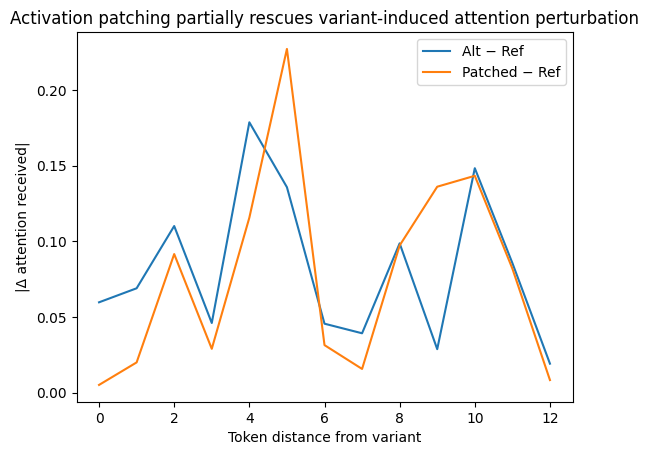

In [44]:
max_dist = 25

def dist_profile(delta, var_token, max_dist):
    prof = []
    for d in range(max_dist + 1):
        vals = []
        for pos in [var_token - d, var_token + d]:
            if 0 <= pos < len(delta):
                vals.append(abs(delta[pos]))
        prof.append(np.mean(vals) if vals else np.nan)
    return np.array(prof)

prof_alt = dist_profile(delta_alt, var_token, max_dist)
prof_patch = dist_profile(delta_patch, var_token, max_dist)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(prof_alt, label="Alt − Ref")
plt.plot(prof_patch, label="Patched − Ref")
plt.xlabel("Token distance from variant")
plt.ylabel("|Δ attention received|")
plt.legend()
plt.title("Activation patching partially rescues variant-induced attention perturbation")
plt.show()


100%|████████████████████████████████████████████████████████████████████████████| 463/463 [00:58<00:00,  7.85it/s]

Computed rescues for 463/463 variants
mean rescue: 0.16279055178165436
median rescue: 0.1668335199356079
min/max rescue: -0.8432033061981201 0.7244776487350464


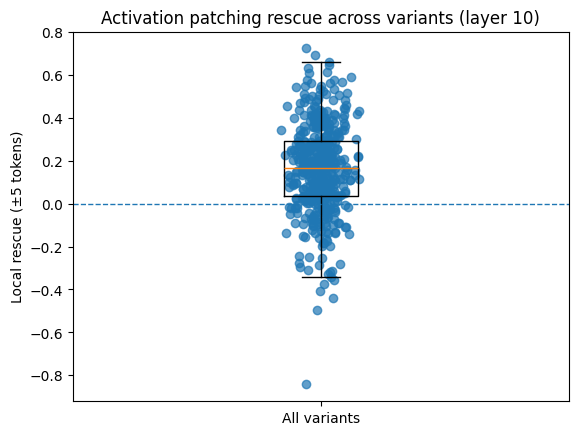

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def local_rescue(delta_alt, delta_patch, var_token, w=5):
    lo = max(0, var_token - w)
    hi = min(len(delta_alt), var_token + w + 1)
    alt_local = np.abs(delta_alt[lo:hi]).sum()
    patch_local = np.abs(delta_patch[lo:hi]).sum()
    return 1.0 - patch_local / (alt_local + 1e-9)

def compute_rescue_for_row(row, patch_block_idx=10, w=5):
    ref_seq = row["ref_sequence"]
    alt_seq = row["alt_sequence"]

    # Baseline ref/alt attentions
    A_ref, ids_ref = get_lastlayer_mean_attention(ref_seq)
    A_alt, ids_alt = get_lastlayer_mean_attention(alt_seq)

    recv_ref = attention_received(A_ref).detach().cpu().numpy()
    recv_alt = attention_received(A_alt).detach().cpu().numpy()
    delta_alt = recv_alt - recv_ref

    # Variant token index
    var_token, diff_tokens = find_variant_token_index(
        ids_ref.detach().cpu(), ids_alt.detach().cpu()
    )
    if var_token is None:
        return None  # skip

    # Patched alt
    (A_ref2,_), (A_alt2,_), (A_patch,_) = get_lastlayer_mean_attention_patched(
        ref_seq=ref_seq,
        alt_seq=alt_seq,
        variant_pos=var_token,
        model=model,
        tokenizer=tokenizer,
        blocks=model.encoder.layer,
        patch_block_idx=patch_block_idx
    )

    recv_patch = attention_received(A_patch).detach().cpu().numpy()
    delta_patch = recv_patch - recv_ref

    rescue = local_rescue(delta_alt, delta_patch, var_token, w=w)
    return rescue

# --------
# RUN IT
# --------
N = 250  # set to 5 if runtime is tight
patch_layer = 10
w = 5

# sample a mix across labels if possible
if "functional_class" in df.columns:
    # try stratified sampling (benign/pathogenic)
    groups = []
    for lab in df["functional_class"].dropna().unique():
        sub = df[df["functional_class"] == lab]
        if len(sub) > 0:
            groups.append(sub.sample(n=min(N//2, len(sub)), random_state=1))
    sample_df = pd.concat(groups).drop_duplicates()
    if len(sample_df) < N:
        sample_df = pd.concat([sample_df, df.sample(n=N-len(sample_df), random_state=2)])
else:
    sample_df = df.sample(n=N, random_state=1)

sample_df = sample_df.reset_index(drop=True)

rescues = []
labels = []

for i, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    try:
        r = compute_rescue_for_row(row, patch_block_idx=patch_layer, w=w)
        if r is not None and np.isfinite(r):
            rescues.append(r)
            labels.append(row.get("functional_class", "NA"))
    except Exception as e:
        # skip failures quietly for speed; optionally print(e)
        continue

print(f"Computed rescues for {len(rescues)}/{len(sample_df)} variants")
if len(rescues) > 0:
    print("mean rescue:", float(np.mean(rescues)))
    print("median rescue:", float(np.median(rescues)))
    print("min/max rescue:", float(np.min(rescues)), float(np.max(rescues)))

# -------------
# PLOT: boxplot + jitter
# -------------
plt.figure()
plt.boxplot(rescues, showfliers=False)
x = np.random.normal(1, 0.03, size=len(rescues))  # jitter
plt.scatter(x, rescues, alpha=0.7)
plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel(f"Local rescue (±{w} tokens)")
plt.title(f"Activation patching rescue across variants (layer {patch_layer})")
plt.xticks([1], ["All variants"])
plt.show()


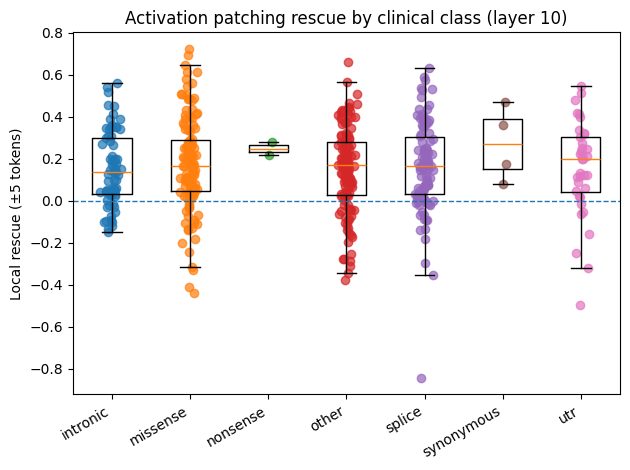

In [50]:
# group rescues by label
plot_df = pd.DataFrame({"rescue": rescues, "label": labels})

labs = sorted(plot_df["label"].unique())
data = [plot_df.loc[plot_df["label"] == lab, "rescue"].values for lab in labs]

plt.figure()
plt.boxplot(data, showfliers=False)
for j, lab in enumerate(labs, start=1):
    vals = plot_df.loc[plot_df["label"] == lab, "rescue"].values
    x = np.random.normal(j, 0.05, size=len(vals))
    plt.scatter(x, vals, alpha=0.7)

plt.axhline(0, linestyle="--", linewidth=1)
plt.ylabel(f"Local rescue (±{w} tokens)")
plt.title(f"Activation patching rescue by clinical class (layer {patch_layer})")
plt.xticks(range(1, len(labs)+1), labs, rotation=30, ha="right")
plt.tight_layout()
plt.show()
